In [1]:
"""IMPORTS"""
import numpy as np
from helpers import *
from implementations import *
from utils import *
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
"""LOADING RAW DATA"""
data_path = 'dataset'
x_tr_raw, x_te_raw, y_tr_raw, train_ids, test_ids = load_csv_data(data_path, sub_sample=False)

In [3]:
"""REMOVE USELESS COLUMNS"""
columns_to_remove = np.concatenate((range(1, 25), range(54, 56)))

x_tr_remove_col = np.delete(x_tr_raw, columns_to_remove, axis=1)
x_te_remove_col = np.delete(x_te_raw, columns_to_remove, axis=1)

"""TREATING SIMILARLY DON'T KNOW, REFUSE AND NAN"""
x_tr_dk = replace_dk_values_with_nan(x_tr_remove_col)
x_te_dk = replace_dk_values_with_nan(x_te_remove_col)

In [4]:
"""SPLITTING TRAINING DATA INTO TRAINING AND VALIDATION"""
x_tr_sp, x_val_sp, y_tr_sp, y_val_sp = split_data(x_tr_dk, y_tr_raw, ratio=0.8, seed=1)

## 1. LEAST SQUARES WITH RAW DATA

In [10]:
import numpy as np

# Define the number of folds (k) for cross-validation
k = 5  # You can choose the number of folds as needed

# Create a KFold cross-validation splitter
kf = np.array_split(np.random.permutation(len(x_tr_raw)), k)

# Initialize lists to store results from each fold
mse_scores = []

for i in range(k):
    # Get the indices for the current fold
    val_index = kf[i]
    train_index = np.concatenate([kf[j] for j in range(k) if j != i])

    # Split the data into training and validation sets for this fold
    x_tr_fold, x_val_fold = x_tr_raw[train_index], x_tr_raw[val_index]
    y_tr_fold, y_val_fold = y_tr_raw[train_index], y_tr_raw[val_index]

    # The rest of your cross-validation code remains the same...

    # Nan to mean
    x_tr_no_nan, x_val_no_nan = nan_to_mean(x_tr_fold, x_val_fold)

    # Remove columns with one unique value
    x_tr_no_unique, x_val_no_unique = remove_uniquevalue_cols(x_tr_no_nan, x_val_no_nan)

    # Standardize
    x_tr_std, x_val_std = standardize(x_tr_no_unique, x_val_no_unique)

    # Duplicate
    x_tr_duplicated, y_tr_duplicated = duplicate_1rows(x_tr_std, y_tr_fold, 0)
    tx_tr = np.c_[np.ones((x_tr_duplicated.shape[0], 1)), x_tr_duplicated]

    # Perform least squares regression for this fold
    w_LS, mse_LS = least_squares(y_tr_duplicated, tx_tr)

    # Evaluate the model on the validation set for this fold
    f1 = predict_and_evaluate(x_val_std, w_LS, y_val_fold)

    # Append the MSE score for this fold to the list
    mse_scores.append(f1)

# Calculate the average MSE over all folds
average_mse = np.mean(mse_scores)

print(f'Average F1 score over {k}-fold cross-validation: {average_mse}')


Accuracy: 0.9126274246880095
F1-score: 0.27085452695829093
Accuracy: 0.9103722553217426
F1-score: 0.26548451548451546
Accuracy: 0.9115760281591418
F1-score: 0.2584025559105431
Accuracy: 0.9106465326770994
F1-score: 0.26201862572363455
Accuracy: 0.9097627500876164
F1-score: 0.25993501624593846
Average F1 score over 5-fold cross-validation: 0.26333904806458447


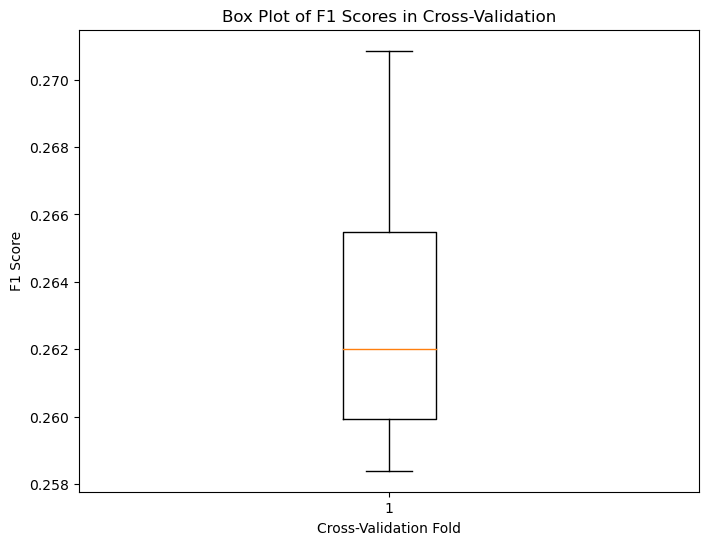

In [11]:
import matplotlib.pyplot as plt

# Assuming you have the `mse_scores` list from the previous code
# If not, make sure to compute it using cross-validation

# Create a box plot of the MSE scores
plt.figure(figsize=(8, 6))
plt.boxplot(mse_scores)
plt.title('Box Plot of F1 Scores in Cross-Validation')
plt.xlabel('Cross-Validation Fold')
plt.ylabel('F1 Score')
plt.show()

## 2. LEAST SQUARES OPTIMIZE DUPLICATIONS

1


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.9106770079388057
F1-score: 0.2572225038013178


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.9120179194538833
F1-score: 0.2627681307456588


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.9105398692611273
F1-score: 0.25655312143852094


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.9117588797293796
F1-score: 0.27711896142803644


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.9105398692611273
F1-score: 0.26640009996251407
-----------------------------------------
2


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.8942660795099578
F1-score: 0.37928258341533233


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.8951346244685876
F1-score: 0.3906499026031521


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.8947232084355524
F1-score: 0.3874456955403848


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.894784158958965
F1-score: 0.39253980821676787


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.8940679903088667
F1-score: 0.39145658263305316
-----------------------------------------
3


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.8702668109162387
F1-score: 0.405695937456373


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.869901107775763
F1-score: 0.4082339894649293


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.8156703795693846
F1-score: 0.3215747854859514


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.8719277126792326
F1-score: 0.41845983532830555


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.8700230088225883
F1-score: 0.41326179667079377
-----------------------------------------
4


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.8463437304767855
F1-score: 0.4052141087648932


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.8454447102564493
F1-score: 0.4047884513819612


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.846587532570436
F1-score: 0.41060765718299963
Accuracy: 0.8481570085483109
F1-score: 0.41482177461976627


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.846389443369345
F1-score: 0.4147460087082729
-----------------------------------------
5


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.8241120270620323
F1-score: 0.39895860453007026


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.82318253157999
F1-score: 0.39769542198691993


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.8242339281088576
F1-score: 0.4018046984390396


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.8256967406707605
F1-score: 0.40344198174706647


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.8238225120758225
F1-score: 0.40352868345026827
-----------------------------------------
6


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.8032364727932101
F1-score: 0.38751600815823173


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.8022917396803145
F1-score: 0.38574066183780714


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.8049126121870571
F1-score: 0.39485749397362574


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.7897206942264616
F1-score: 0.37003560668310054


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.802931720176147
F1-score: 0.3936424586244081
-----------------------------------------
7


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.7847684641991863
F1-score: 0.3778903325258754


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.7828637603425419
F1-score: 0.3759852863899106


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.786017949929145
F1-score: 0.38502299102255316


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.7875721882761668
F1-score: 0.38610242635078607


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.7832294634830177
F1-score: 0.38158581116327595
-----------------------------------------
8


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.7674432779191491
F1-score: 0.3687649929688146


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.7647919301507001
F1-score: 0.366442291906091


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.7683727734011916
F1-score: 0.3756520310510535


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.7703079525195423
F1-score: 0.3773647253201156


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.7667118716381977
F1-score: 0.3729007946260342
-----------------------------------------
9


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.7506818839806787
F1-score: 0.35985915492957743


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.7491276456336569
F1-score: 0.3580285424627623


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.751687567616987
F1-score: 0.3664567296477724


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.7540798756609323
F1-score: 0.3686578257637992


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.7508799731817697
F1-score: 0.36535848763634954
-----------------------------------------
10


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.7347737973699849
F1-score: 0.3509099045346062


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.7336766879485578
F1-score: 0.3488562700245883


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.7359928078382373
F1-score: 0.35763013495476786


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.7393907995184908
F1-score: 0.35998952213449087


c:\Users\hany_\anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Accuracy: 0.7359470949456779
F1-score: 0.357828423198073
-----------------------------------------


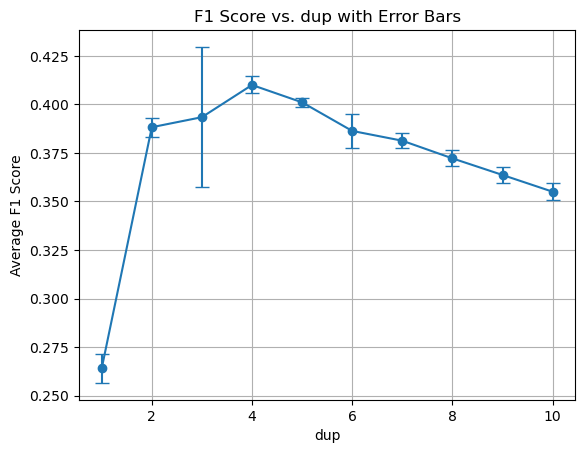

In [16]:
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Define the number of folds (k) for cross-validation
k = 5 # You can choose the number of folds as needed

# Define a list of values for dup to loop through
dup_values = range(1, 11)  # Goes from 0 to 10

# Initialize a list to store average F1 scores for each dup value
average_f1_scores = []
std_dev_f1_scores = []  # List to store standard deviation of F1 scores


for dup in dup_values:
    print(dup)
    # Create a KFold cross-validation splitter
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Initialize a list to store F1 scores for this dup value
    f1_scores = []

    for train_index, val_index in kf.split(x_tr_dk):
        train_index = train_index[train_index < len(x_tr_raw)]  # Ensure indices are within bounds
        val_index = val_index[val_index < len(x_tr_raw)]  # Ensure indices are within bounds

        # Split the data into training and validation sets for this fold
        x_tr_fold, x_val_fold = x_tr_raw[train_index], x_tr_raw[val_index]
        y_tr_fold, y_val_fold = y_tr_raw[train_index], y_tr_raw[val_index]

        # The rest of your cross-validation code remains the same...

        # Standardize and preprocess the data for this fold
        x_tr_std, x_val_std = standardize(x_tr_fold, x_val_fold)
        x_tr_no_nan, x_val_no_nan = nan_to_zero(x_tr_std, x_val_std)
        x_tr_duplicated, y_tr_duplicated = duplicate_1rows(x_tr_no_nan, y_tr_fold, dup)

        tx_tr = np.c_[np.ones((x_tr_duplicated.shape[0], 1)), x_tr_duplicated]

        # Perform least squares regression for this fold
        w_LS, mse_LS = least_squares(y_tr_duplicated, tx_tr)

        # Evaluate the model on the validation set for this fold
        f1 = predict_and_evaluate(x_val_no_nan, w_LS, y_val_fold)
                
        # Append the F1 score for this fold to the list
        f1_scores.append(f1)

    # Calculate the average F1 score over all folds for this dup value
    # Calculate the average F1 score and standard deviation over all folds for this dup value
    average_f1 = np.mean(f1_scores)
    std_dev_f1 = np.std(f1_scores)
    average_f1_scores.append(average_f1)
    std_dev_f1_scores.append(std_dev_f1)
    print("-----------------------------------------")

# Create an error plot with error bars
plt.figure()
plt.errorbar(dup_values, average_f1_scores, yerr=std_dev_f1_scores, marker='o', linestyle='-', capsize=5)
plt.xlabel('dup')
plt.ylabel('Average F1 Score')
plt.title('F1 Score vs. dup with Error Bars')
plt.grid(True)
plt.show()

In [11]:
from sklearn.model_selection import KFold
import numpy as np

# Define the number of folds (k) for cross-validation
k = 5 # You can choose the number of folds as needed
dup = 3

# Create a KFold cross-validation splitter
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store results from each fold
f1_step1 = []

for train_index, val_index in kf.split(x_tr_dk):
    train_index = train_index[train_index < len(x_tr_raw)]  # Ensure indices are within bounds
    val_index = val_index[val_index < len(x_tr_raw)]  # Ensure indices are within bounds

    # Split the data into training and validation sets for this fold
    x_tr_fold, x_val_fold = x_tr_raw[train_index], x_tr_raw[val_index]
    y_tr_fold, y_val_fold = y_tr_raw[train_index], y_tr_raw[val_index]

    # The rest of your cross-validation code remains the same...

    # Standardize and preprocess the data for this fold
    x_tr_std, x_val_std = standardize(x_tr_fold, x_val_fold)
    x_tr_no_nan, x_val_no_nan = nan_to_zero(x_tr_std, x_val_std)
    x_tr_duplicated, y_tr_duplicated = duplicate_1rows(x_tr_no_nan, y_tr_fold, dup)

    tx_tr = np.c_[np.ones((x_tr_duplicated.shape[0], 1)), x_tr_duplicated]

    # Perform least squares regression for this fold
    w_LS, mse_LS = least_squares(y_tr_duplicated, tx_tr)

    # Evaluate the model on the validation set for this fold
    f1 = predict_and_evaluate(x_val_no_nan, w_LS, y_val_fold)
    
    # Append the MSE score for this fold to the list
    f1_step1.append(f1)

# Calculate the average MSE over all folds
average_mse = np.mean(f1_step1)

print(f'Average F1 score over {k}-fold cross-validation: {average_mse}')

Accuracy: 0.8735733768113734
F1-score: 0.4079069435524156
Accuracy: 0.875798070915934
F1-score: 0.42129925452609157
Accuracy: 0.8742590701997653
F1-score: 0.4117479327060165
Accuracy: 0.8742438325689121
F1-score: 0.4251584592881521
Accuracy: 0.8736952778581986
F1-score: 0.4296428817174706
Average F1 score over 5-fold cross-validation: 0.4191510943580292


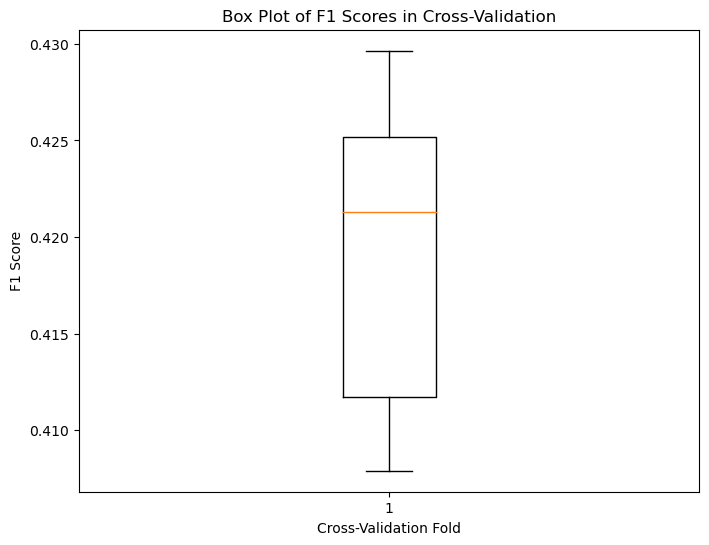

In [13]:
import matplotlib.pyplot as plt

# Assuming you have the `mse_scores` list from the previous code
# If not, make sure to compute it using cross-validation

# Create a box plot of the MSE scores
plt.figure(figsize=(8, 6))
plt.boxplot(f1_step1)
plt.title('Box Plot of F1 Scores in Cross-Validation')
plt.xlabel('Cross-Validation Fold')
plt.ylabel('F1 Score')
plt.show()

## 3. LEAST SQUARES REMOVE COLUMNS + REPLACE DK AND REFUSE

In [14]:
from sklearn.model_selection import KFold
import numpy as np

# Define the number of folds (k) for cross-validation
k = 5 # You can choose the number of folds as needed
dup = 3

# Create a KFold cross-validation splitter
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store results from each fold
f1_step2 = []

for train_index, val_index in kf.split(x_tr_dk):
    train_index = train_index[train_index < len(x_tr_dk)]  # Ensure indices are within bounds
    val_index = val_index[val_index < len(x_tr_dk)]  # Ensure indices are within bounds

    # Split the data into training and validation sets for this fold
    x_tr_fold, x_val_fold = x_tr_dk[train_index], x_tr_dk[val_index]
    y_tr_fold, y_val_fold = y_tr_raw[train_index], y_tr_raw[val_index]

    # The rest of your cross-validation code remains the same...

    # Standardize and preprocess the data for this fold
    x_tr_std, x_val_std = standardize(x_tr_fold, x_val_fold)
    x_tr_no_nan, x_val_no_nan = nan_to_zero(x_tr_std, x_val_std)
    x_tr_duplicated, y_tr_duplicated = duplicate_1rows(x_tr_no_nan, y_tr_fold, dup)

    tx_tr = np.c_[np.ones((x_tr_duplicated.shape[0], 1)), x_tr_duplicated]

    # Perform least squares regression for this fold
    w_LS, mse_LS = least_squares(y_tr_duplicated, tx_tr)

    # Evaluate the model on the validation set for this fold
    f1 = predict_and_evaluate(x_val_no_nan, w_LS, y_val_fold)
    
    # Append the MSE score for this fold to the list
    f1_step2.append(f1)

# Calculate the average MSE over all folds
average_mse = np.mean(f1_step2)

print(f'Average F1 score over {k}-fold cross-validation: {average_mse}')


Accuracy: 0.8735733768113734
F1-score: 0.4079069435524156
Accuracy: 0.875798070915934
F1-score: 0.42129925452609157
Accuracy: 0.8742590701997653
F1-score: 0.4117479327060165
Accuracy: 0.8742438325689121
F1-score: 0.4251584592881521
Accuracy: 0.8736952778581986
F1-score: 0.4296428817174706
Average F1 score over 5-fold cross-validation: 0.4191510943580292


In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the `mse_scores` list from the previous code
# If not, make sure to compute it using cross-validation

# Create a box plot of the MSE scores
plt.figure(figsize=(8, 6))
plt.boxplot(f1_step2)
plt.title('Box Plot of F1 Scores in Cross-Validation')
plt.xlabel('Cross-Validation Fold')
plt.ylabel('F1 Score')
plt.show()

## 4. RIGDE REGRESSION

In [ ]:
from sklearn.model_selection import KFold
import numpy as np

# Define the number of folds (k) for cross-validation
k = 5 # You can choose the number of folds as needed
dup = 3
lambda_ = 0.0009

# Create a KFold cross-validation splitter
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store results from each fold
f1_step3 = []

for train_index, val_index in kf.split(x_tr_dk):
    train_index = train_index[train_index < len(x_tr_dk)]  # Ensure indices are within bounds
    val_index = val_index[val_index < len(x_tr_dk)]  # Ensure indices are within bounds

    # Split the data into training and validation sets for this fold
    x_tr_fold, x_val_fold = x_tr_dk[train_index], x_tr_dk[val_index]
    y_tr_fold, y_val_fold = y_tr_raw[train_index], y_tr_raw[val_index]

    # The rest of your cross-validation code remains the same...

    # Standardize and preprocess the data for this fold
    x_tr_std, x_val_std = standardize(x_tr_fold, x_val_fold)
    x_tr_no_nan, x_val_no_nan = nan_to_zero(x_tr_std, x_val_std)
    x_tr_duplicated, y_tr_duplicated = duplicate_1rows(x_tr_no_nan, y_tr_fold, dup)

    tx_tr = np.c_[np.ones((x_tr_duplicated.shape[0], 1)), x_tr_duplicated]

    # Perform least squares regression for this fold
    w_LS, mse_LS = ridge_regression(y_tr_duplicated, tx_tr, lambda_)

    # Evaluate the model on the validation set for this fold
    f1 = predict_and_evaluate(x_val_no_nan, w_LS, y_val_fold)
    
    # Append the MSE score for this fold to the list
    f1_step4.append(f1)

# Calculate the average MSE over all folds
average_mse = np.mean(f1_step3)

print(f'Average F1 score over {k}-fold cross-validation: {average_mse}')


In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the `mse_scores` list from the previous code
# If not, make sure to compute it using cross-validation

# Create a box plot of the MSE scores
plt.figure(figsize=(8, 6))
plt.boxplot(mse_scores)
plt.title('Box Plot of F1 Scores in Cross-Validation')
plt.xlabel('Cross-Validation Fold')
plt.ylabel('F1 Score')
plt.show()

## 5. POLYNOMIAL RIDGE REGRESSION

In [ ]:
from sklearn.model_selection import KFold
import numpy as np

# Define the number of folds (k) for cross-validation
k = 5 # You can choose the number of folds as needed
dup = 3
lambda_ = 0.00028
degree = 5

# Create a KFold cross-validation splitter
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store results from each fold
f1_step4 = []

for train_index, val_index in kf.split(x_tr_dk):
    train_index = train_index[train_index < len(x_tr_dk)]  # Ensure indices are within bounds
    val_index = val_index[val_index < len(x_tr_dk)]  # Ensure indices are within bounds

    # Split the data into training and validation sets for this fold
    x_tr_fold, x_val_fold = x_tr_dk[train_index], x_tr_dk[val_index]
    y_tr_fold, y_val_fold = y_tr_raw[train_index], y_tr_raw[val_index]

    # The rest of your cross-validation code remains the same...

    # Standardize and preprocess the data for this fold
    x_tr_std, x_val_std = standardize(x_tr_fold, x_val_fold)
    x_tr_no_nan, x_val_no_nan = nan_to_zero(x_tr_std, x_val_std)
    x_tr_duplicated, y_tr_duplicated = duplicate_1rows(x_tr_no_nan, y_tr_fold, dup)

    x_poly_tr = build_poly(x_tr_duplicated, degree)
    x_poly_val = build_poly(x_val_no_nan, degree)

    tx_tr = np.c_[np.ones((x_poly_tr.shape[0], 1)), x_poly_tr]

    # Perform least squares regression for this fold
    w_LS, mse_LS = ridge_regression(y_tr_duplicated, tx_tr, lambda_)

    # Evaluate the model on the validation set for this fold
    f1 = predict_and_evaluate(x_poly_val, w_LS, y_val_fold)
    
    # Append the MSE score for this fold to the list
    f1_step4.append(f1)

# Calculate the average MSE over all folds
average_mse = np.mean(f1_step4)

print(f'Average F1 score over {k}-fold cross-validation: {average_mse}')


In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the `mse_scores` list from the previous code
# If not, make sure to compute it using cross-validation

# Create a box plot of the MSE scores
plt.figure(figsize=(8, 6))
plt.boxplot(mse_scores)
plt.title('Box Plot of F1 Scores in Cross-Validation')
plt.xlabel('Cross-Validation Fold')
plt.ylabel('F1 Score')
plt.show()

## FINAL BOX PLOT

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the `f1_step1`, `f1_step2`, `f1_step3`, and `f1_step` lists from your data
# If not, make sure to have these lists with your F1 scores

# Create a box plot of the F1 scores
plt.figure(figsize=(8, 6))

# Create a boxplot for each step and add it to the legend
plt.boxplot(f1_step1, positions=[1], label='Step 1', notch=True)
plt.boxplot(f1_step2, positions=[2], label='Step 2', notch=True)
plt.boxplot(f1_step3, positions=[3], label='Step 3', notch=True)
plt.boxplot(f1_step4, positions=[4], label='Step', notch=True)

plt.title('Box Plot of F1 Scores in Cross-Validation')
plt.xlabel('Cross-Validation Fold')
plt.ylabel('F1 Score')

# Add a legend to the plot
plt.legend()

# Set the x-axis ticks and labels
plt.xticks([1, 2, 3, 4], ['Step 1', 'Step 2', 'Step 3', 'Step'])

plt.show()